In [2]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import random
import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import defaultdict
pio.renderers.default = 'notebook_connected'

import os
sns.set()

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

if 'notebook' in os.getcwd():
    os.chdir('..')

import gym
import gym.envs.toy_text
import copy 

# Temporal Differencing (TD)

An approach that combines the benifits of Dynamic Programming (DP) and Monte Carlo (MC) by using bootstrapping from DP and the sample-based approach from MC. Below is the implementation of TD(0) where the 0 refers to one less than how many future states are discounted.

$$ V'(s) = V(s) + \alpha[R + \lambda V(s') - V(s)]$$
$$ Q'(s,a) = Q(s,a) + \alpha[R + \lambda Q(s',a') - Q(s',a')]$$

where:
- $V(s)$: Current value of a state
- $V'(s)$: New value of a state
- $s$: current state
- $s'$: next state after an action is taken
- $\alpha$: learning rate
- $a$: action
- $\lambda$: discount factor

# Cart Pole Environment

In [3]:
env = gym.make("CartPole-v1")
print('Action Space:', env.action_space)
print('Observation Space:', env.observation_space)

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [32]:
def discretize_observation(x):
    """Discretizes the observation space to a fixed number of bins. Please change me"""
    
    x = np.clip(x, -10_000, 10_000)
    x_max = np.clip(env.observation_space.high, -10_000, 10_000)
    x_min = np.clip(env.observation_space.low, -10_000, 10_000)
    
    x = (x - x_min) / (x_max - x_min)
    
    return tuple([int(xi * 100) for xi in x])

In [33]:
discretize_observation(env.reset())

(49, 49, 50, 50)

# State-Actio-Reward-State-Action (SARSA)

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [34]:
# SARSA Learning agent class

class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        """ Implementation of a SARSA model.

        Args:
            alpha (float): Learning rate when updating the Q values.
            epsilon (float): Probability to produce random action.
            gamma (flaot): Discount factor
            get_possible_actions (list): List of possible actions to return.
        """
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0)) # Q-values of unseen state-action pairs default to 0.

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        # Implement temporal differencing
        if not done:
            # Calculate future discounted reward
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            # No future discounter reward
            td_error = reward - self.get_Q(state, action)

        # Update Q-value
        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [35]:
# training algorithm
def train_sarsa_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        state = discretize_observation(state)
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_observation(next_state)
            
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [82]:
# plot rewards
def plot_rewards(env_name, rewards, label, n = 20):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-n:])))
    rewards_mean = np.array([np.nan] * len(rewards))
    for i in range(n,len(rewards)):
        rewards_mean[i] = rewards[i-n:i].mean()
    plt.plot(rewards, label=label)
    plt.plot(rewards_mean, label=label + '_mean')
    plt.grid()
    plt.legend()
    plt.show()

In [83]:
# create a SARSA agent
sarsa_agent = SARSAAgent(
            alpha=0.2,
            epsilon=0.2,
            gamma=0.995,
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_sarsa_agent(env, sarsa_agent, episode_cnt = 1000)

In [84]:
len(sarsa_agent._Q)

1162

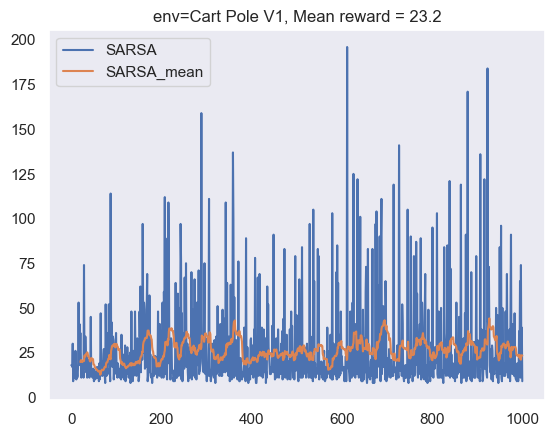

In [85]:
# plot rewards
plot_rewards("Cart Pole V1", rewards, 'SARSA')

In [51]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
sarsa_agent.epsilon = 0.0

for t in range(tmax):
    state = discretize_observation(state)
    action = sarsa_agent.get_action(state)
    
    env_run.render(mode = 'human')
    next_state, reward, done, _ = env_run.step(action)
    G += reward
    if done:
        break

    time.sleep(0.1)

print(f'lasted for {t} steps')
env_run.close()

lasted for 24 steps


# Q-Learning

This is in on-policy control algorithm. It sample step by step and updates the Q values where the learning rate can be controlled. 

In [52]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        """ Implementation of a Q-learning model.

        Args:
            alpha (float): Learning rate when updating the Q values.
            epsilon (float): Probability to produce random action.
            gamma (flaot): Discount factor
            get_possible_actions (list): List of possible actions to return.
        """
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, best_next_action) \
                       - self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [53]:
# training algorithm
def train_q_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state = env.reset()
        state = discretize_observation(state)
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_observation(next_state)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [89]:
# create a Q Learning agent
q_agent = QLearningAgent(alpha=0.2, epsilon=0.2, gamma=0.995, 
                       get_possible_actions=lambda s : range(env.action_space.n))

#train agent and get rewards for episodes
rewards = train_q_agent(env, q_agent, episode_cnt = 1000)

In [90]:
len(q_agent._Q)

1000

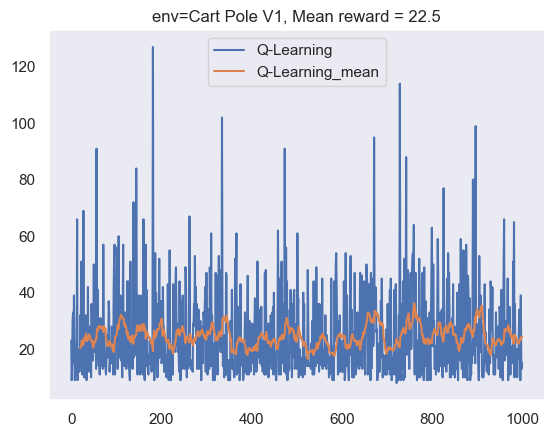

In [91]:
# Plot rewards
plot_rewards("Cart Pole V1",rewards, 'Q-Learning')

In [69]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
q_agent.epsilon = 0.0
for t in range(tmax):
    env_run.render(mode = 'human')
    
    state = discretize_observation(state)
    action = q_agent.get_action(state)

    next_state, reward, done, _ = env_run.step(action)
    G += reward
    if done:
        break
    state = next_state

    time.sleep(0.1)

print(f'lasted for {t} steps with a score of {G}')
env_run.close()

lasted for 18 steps with a score of 19.0


## Hyperparameter tuning

In [102]:
import optuna
from optuna.visualization import *

In [103]:
env_run = copy.deepcopy(env)

In [127]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-6, 5e-1) #trial.suggest_float("alpha", 1e-6, 5e-1, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-6, 9e-1) #trial.suggest_float("epsilon", 1e-6, 9e-1, log=True)
    
    # create a Q Learning agent
    q_agent = QLearningAgent(alpha=alpha, epsilon=epsilon, gamma=0.995, 
                        get_possible_actions=lambda s : range(env.action_space.n))

    #train agent and get rewards for episodes
    train_q_agent(env, q_agent, episode_cnt = 300)
    
    # Evaluate Agent
    tmax = 10000
    G = 0

    state = env_run.reset()
    q_agent.epsilon = -1.0
    for t in range(tmax):
        state = discretize_observation(state)
        action = q_agent.get_action(state)

        next_state, reward, done, _ = env_run.step(action)
        G += reward
        if done:
            break
        state = next_state
    return G

In [128]:
study = optuna.create_study(direction = 'maximize')

[I 2023-07-14 23:12:34,019] A new study created in memory with name: no-name-15d21634-a283-414b-ac76-dc5ce84945a6


In [129]:
study.optimize(objective, n_trials = 1000)

[I 2023-07-14 23:12:42,287] Trial 0 finished with value: 29.0 and parameters: {'alpha': 0.10928510076299275, 'epsilon': 0.4094450774732191}. Best is trial 0 with value: 29.0.
[I 2023-07-14 23:12:42,876] Trial 1 finished with value: 18.0 and parameters: {'alpha': 0.37916282302830273, 'epsilon': 0.1596682661897461}. Best is trial 0 with value: 29.0.
[I 2023-07-14 23:12:43,403] Trial 2 finished with value: 22.0 and parameters: {'alpha': 0.14146725834651658, 'epsilon': 0.12713937042748105}. Best is trial 0 with value: 29.0.
[I 2023-07-14 23:12:43,807] Trial 3 finished with value: 8.0 and parameters: {'alpha': 0.2875199150576856, 'epsilon': 0.8599405506242583}. Best is trial 0 with value: 29.0.
[I 2023-07-14 23:12:44,270] Trial 4 finished with value: 19.0 and parameters: {'alpha': 0.31850541921476005, 'epsilon': 0.12498507160188073}. Best is trial 0 with value: 29.0.
[I 2023-07-14 23:12:44,743] Trial 5 finished with value: 25.0 and parameters: {'alpha': 0.3059759868550111, 'epsilon': 0.7298

In [ ]:
fig = plot_parallel_coordinate(study)
fig.show()

In [ ]:
trial = study.best_trial

print('Best trial value:', trial.value)
for key, value in trial.params.items():
    print(f'{key} = {value},')

Best trial value: 154.0
alpha = 0.00016089562837960736,
epsilon = 1.4570458994718415e-06,


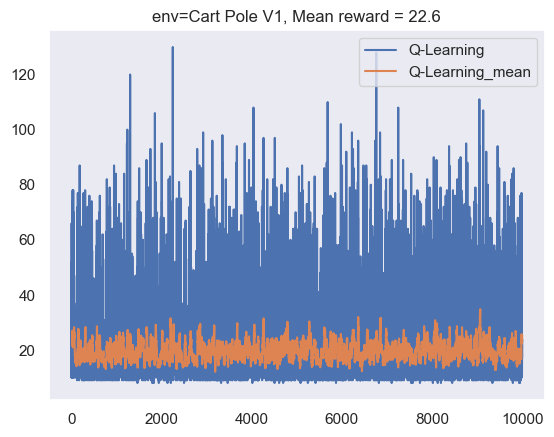

In [ ]:
# create a Q Learning agent
q_agent = QLearningAgent(gamma=0.995, 
                       get_possible_actions=lambda s : range(env.action_space.n),
                       **trial.params)

#train agent and get rewards for episodes
rewards = train_q_agent(env, q_agent, episode_cnt = 10000)

# Plot rewards
plot_rewards("Cart Pole V1",rewards, 'Q-Learning')

In [ ]:
tmax = 10000
G = 0

env_run = copy.deepcopy(env)
state = env_run.reset()
q_agent.epsilon = -1.0
for t in range(tmax):
    env_run.render(mode = 'human')
    
    state = discretize_observation(state)
    action = q_agent.get_action(state)

    next_state, reward, done, _ = env_run.step(action)
    G += reward
    if done:
        break
    state = next_state

    time.sleep(0.1)

print(f'lasted for {t} steps with a score of {G}')
env_run.close()

lasted for 13 steps with a score of 14.0
